In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 22.4 MB/s eta 0:00:0000:01


Found 6563 validated image filenames belonging to 38 classes.
Found 2188 validated image filenames belonging to 38 classes.
Found 10547 validated image filenames belonging to 38 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.1984 - loss: 5.4597 - val_accuracy: 0.1357 - val_loss: 3.2558
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.3759 - loss: 3.4897 - val_accuracy: 0.1915 - val_loss: 3.0632
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.5193 - loss: 2.5602 - val_accuracy: 0.1860 - val_loss: 5.1224
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.5878 - loss: 2.0246 - val_accuracy: 0.3419 - val_loss: 2.8479
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.6306 - loss: 1.6635 - val_accuracy: 0.4324 - val_loss: 2.3184
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.6795 - loss: 1.4440 - val_accuracy: 0.5055 - val_loss: 1.8734
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.7210 - loss: 1.1436 - val_accuracy: 0.6906 - val_loss: 1.0134
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.7264 - loss: 1.1089 - val_accuracy: 0.667

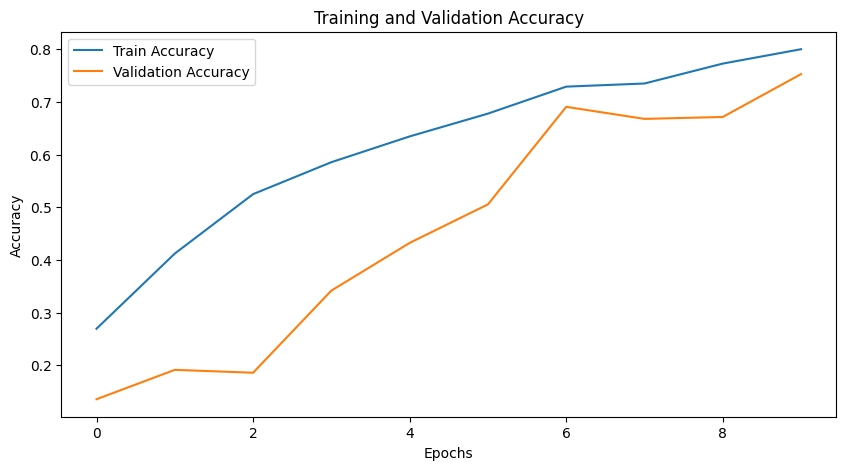

330/330 ━━━━━━━━━━━━━━━━━━━━ 183s 554ms/step


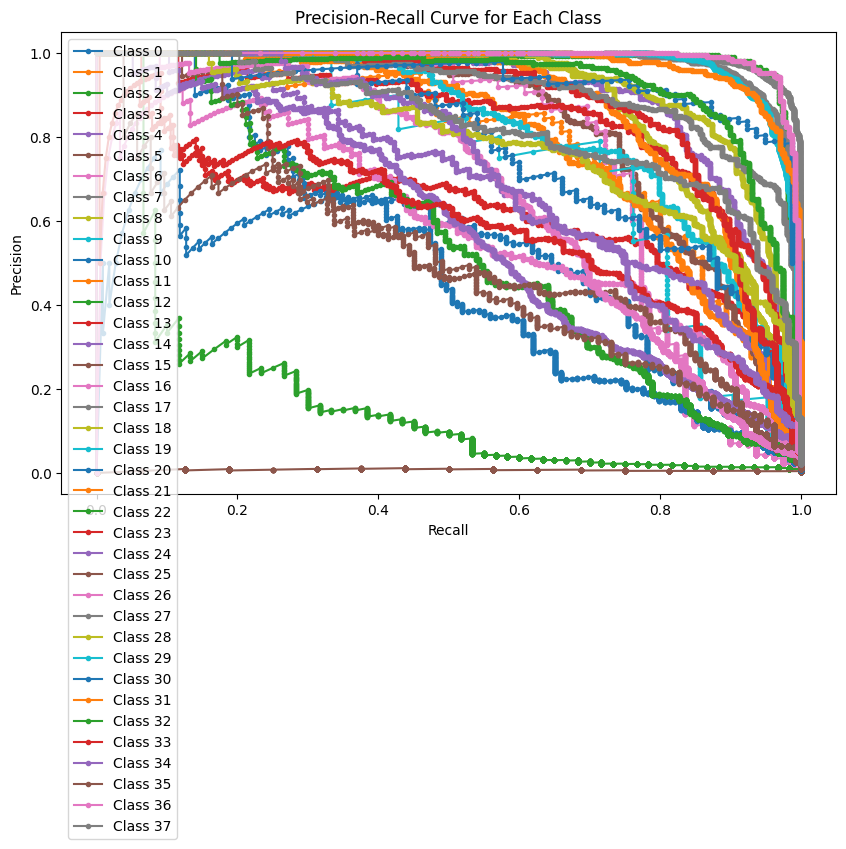

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/plantvillage-dataset/data_distribution_for_SVM"

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {str(i): i for i in range(38)}

# Collect images and labels from the train folder
train_folder = os.path.join(dataset_path, "train")
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

# Split train into 75% training and 25% validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

# Collect images and labels from the test folder (keep as is)
test_imgs, test_labels = [], []
test_folder = os.path.join(dataset_path, "test")
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    for img_file in os.listdir(label_path):
        test_imgs.append(os.path.join(label_path, img_file))
        test_labels.append(label_map[label])

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Data Generator
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False)

# Define AlexNet model
def create_alexnet(input_shape=(224, 224, 3), num_classes=38):
    model = Sequential([
        # First Convolutional Layer
        Conv2D(96, (11, 11), strides=(4, 4), input_shape=input_shape, padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        BatchNormalization(),
        
        # Second Convolutional Layer
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        BatchNormalization(),
        
        # Third, Fourth, and Fifth Convolutional Layers
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        # Fully Connected Layers
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the model
model = create_alexnet()
model.compile(optimizer=SGD(learning_rate=0.0007, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=10, class_weight=class_weight_dict)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
y_true = tf.keras.utils.to_categorical(test_gen.classes, 38)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(38):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()